In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Zach FLowers, Jongho Lee, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

## Imports

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from tqdm import tqdm
from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess

import sqlite3


# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_name = "ET2 W36 IP5-18"

## Set defaults

In [3]:
# 'If set, the full log will be saved to a file (i.e. the log level is ignored)'
log_file = False
# 'Set the logging level. Default: WARNING',
#  ["CRITICAL","ERROR","WARNING","INFO","DEBUG","TRACE","DETAILED_TRACE","NOTSET"]
log_level_text = "WARNING"
# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
chip_address = 0x60
ws_address = None

In [4]:
if log_file:
    logging.basicConfig(filename='logging.log', filemode='w', encoding='utf-8', level=logging.NOTSET)
    log_level = 0
else:
    log_level = 0
    if log_level_text == "CRITICAL":
        log_level=50
    elif log_level_text == "ERROR":
        log_level=40
    elif log_level_text == "WARNING":
        log_level=30
    elif log_level_text == "INFO":
        log_level=20
    elif log_level_text == "DEBUG":
        log_level=10
    elif log_level_text == "TRACE":
        log_level=8
    elif log_level_text == "DETAILED_TRACE":
        log_level=5
    elif log_level_text == "NOTSET":
        log_level=0
    logging.basicConfig(format='%(asctime)s - %(levelname)s:%(name)s:%(message)s')

i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
#i2c_gui.__no_connect_type__ = "check"  # default behaviour

## Start logger and connect

In [5]:
logger = logging.getLogger("Script_Logger")

Script_Helper = i2c_gui.ScriptHelper(logger)

## USB ISS connection
conn = i2c_gui.Connection_Controller(Script_Helper)
conn.connection_type = "USB-ISS"
conn.handle: USB_ISS_Helper
conn.handle.port = port
conn.handle.clk = 100

## For FPGA connection (not yet fully implemented)
#conn.connection_type = "FPGA-Eth"
#conn.handle: FPGA_ETH_Helper
#conn.handle.hostname = "192.168.2.3"
#conn.handle.port = "1024"

conn.connect()

In [6]:
chip = i2c_gui.chips.ETROC2_Chip(parent=Script_Helper, i2c_controller=conn)
chip.config_i2c_address(chip_address)  # Not needed if you do not access ETROC registers (i.e. only access WS registers)
# chip.config_waveform_sampler_i2c_address(ws_address)  # Not needed if you do not access WS registers

logger.setLevel(log_level)

## Useful Functions

In [7]:
def pixel_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_indexed_var("ETROC2", "Pixel Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)

def pixel_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_indexed_var("ETROC2", f"Pixel {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Pixel {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

def peripheral_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)

def peripheral_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_display_var("ETROC2", f"Peripheral {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Peripheral {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

## PIxel ID check

In [8]:
Failure_map = np.zeros((16,16))
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        fetched_row = pixel_decoded_register_read("PixelID-Row", "Status", need_int=True)
        fetched_col = pixel_decoded_register_read("PixelID-Col", "Status", need_int=True)
        if(row!=fetched_row or col!=fetched_col):
            print("Fail!", row, col, fetched_row, fetched_col)
            Failure_map[15-row,15-col] = 1

In [9]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

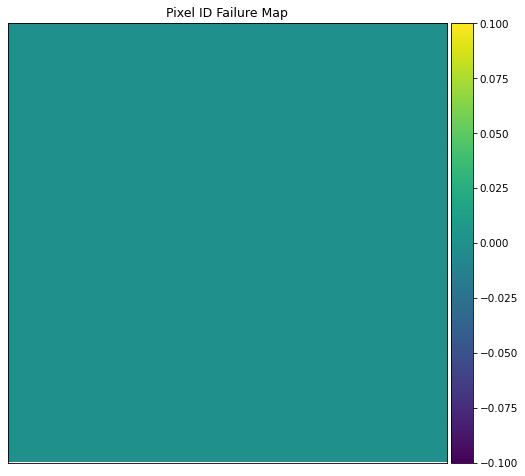

In [10]:
fig = plt.figure(dpi=75, figsize=(8,8))
gs = fig.add_gridspec(1,1)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("Pixel ID Failure Map")
img0 = ax0.imshow(Failure_map, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

plt.show()

## Set Peripheral Registers

In [10]:
peripheral_decoded_register_write("EFuse_Prog", format(0x00017f0f, '032b'))
peripheral_decoded_register_write("singlePort", '1')
peripheral_decoded_register_write("serRateLeft", '00')
peripheral_decoded_register_write("serRateRight", '00')
peripheral_decoded_register_write("onChipL1AConf", '00')
peripheral_decoded_register_write("PLL_ENABLEPLL", '1')
peripheral_decoded_register_write("chargeInjectionDelay", format(0x0a, '05b'))
# peripheral_decoded_register_write("fcClkDelayEn", "0")

In [ ]:
for key in register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"].keys():
    print(key, ":", peripheral_decoded_register_read(key, "Config"))

In [ ]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

column_indexer_handle.set(0)
row_indexer_handle.set(0)

for key in register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"].keys():
    print(key, ":", pixel_decoded_register_read(key, "Config"))

for key in register_decoding["ETROC2"]["Register Blocks"]["Pixel Status"].keys():
    print(key, ":", pixel_decoded_register_read(key, "Status"))

## Reset Chip O/P

In [ ]:
# Reset output, active low
peripheral_decoded_register_write("asyResetGlobalReadout", '0')
peripheral_decoded_register_write("asyResetGlobalReadout", '1')

## LINK RESET

In [ ]:
peripheral_decoded_register_write("asyLinkReset", '1')

In [ ]:
## Low for real data
peripheral_decoded_register_write("asyLinkReset", '0')

## Re-Align Fast Command

In [ ]:
peripheral_decoded_register_write("asyAlignFastcommand", "1")
peripheral_decoded_register_write("asyAlignFastcommand", "0")

## Auto-calibrate all pixels

In [11]:
BL_map_THCal = np.zeros((16,16))
NW_map_THCal = np.zeros((16,16))

### Auto-calibrate based on broadcast - skip for now

In [ ]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
# Enable THCal clock and buffer, disable bypass
broadcast_handle.set(True)
pixel_decoded_register_write("CLKEn_THCal", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("BufEn_THCal", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("Bypass_THCal", "0")
broadcast_handle.set(True)
pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
# Reset the calibration block (active low)
broadcast_handle.set(True)
pixel_decoded_register_write("RSTn_THCal", "0")
time.sleep(1)
broadcast_handle.set(True)
pixel_decoded_register_write("RSTn_THCal", "1")
time.sleep(0.5)
# Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
broadcast_handle.set(True)
pixel_decoded_register_write("ScanStart_THCal", "1")
time.sleep(4)
broadcast_handle.set(True)
pixel_decoded_register_write("ScanStart_THCal", "0")
time.sleep(0.5)
# Disable clock and buffer before charge injection 
broadcast_handle.set(True)
pixel_decoded_register_write("CLKEn_THCal", "0") 
broadcast_handle.set(True)
pixel_decoded_register_write("BufEn_THCal", "0")
# Set Charge Inj Q to 15 fC
broadcast_handle.set(True)
pixel_decoded_register_write("QSel", format(0x0e, '05b'))

data = []

# Loop for fetching calibrated values
for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        data += [{
            'col': col,
            'row': row,
            'baseline': BL_map_THCal[row, col],
            'noise_width': NW_map_THCal[row, col],
            'timestamp': datetime.datetime.now(),
            'chip_name': chip_name,
        }]

BL_df = pandas.DataFrame(data = data)
        

### Auto-calibrate based on the loop

In [15]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
data = []
# Loop for threshold calibration
for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Maybe required to make this work
        # pixel_decoded_register_write("enable_TDC", "0")
        # pixel_decoded_register_write("testMode_TDC", "0")
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        pixel_decoded_register_write("TH_offset", format(0x04, '06b'))
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        data += [{
            'col': col,
            'row': row,
            'baseline': BL_map_THCal[row, col],
            'noise_width': NW_map_THCal[row, col],
            'timestamp': datetime.datetime.now(),
            'chip_name': chip_name,
        }]
        # Disable clock and buffer before charge injection 
        pixel_decoded_register_write("CLKEn_THCal", "0") 
        pixel_decoded_register_write("BufEn_THCal", "0")
        # Set Charge Inj Q to 15 fC
        pixel_decoded_register_write("QSel", format(0x0e, '05b'))

BL_df = pandas.DataFrame(data = data)

 row: 100%|██████████| 16/16 [01:49<00:00,  6.83s/it]


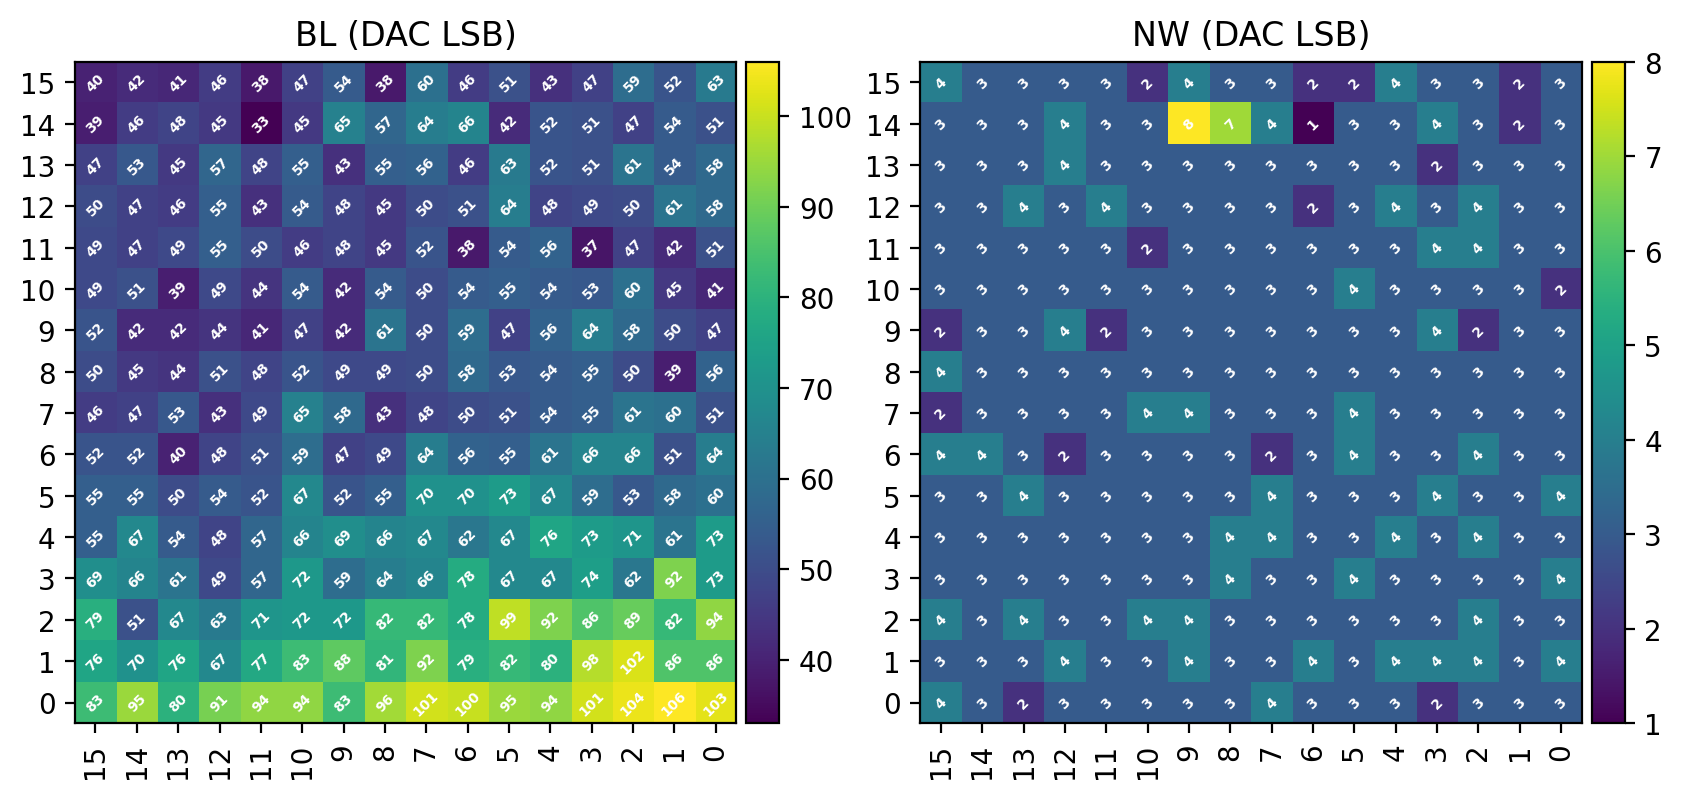

In [16]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL (DAC LSB)")
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("NW (DAC LSB)")
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")

#plt.show()

### Store BL, NW dataframe for later use

In [ ]:
outdir = Path('../ETROC-Data')
outdir = outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
outdir.mkdir(exist_ok=True)
outfile = outdir / ("BaselineAt_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv")
BL_df.to_csv(outfile, index=False)

### Store BL, NW dataframe in database

In [ ]:
new_columns = {
    'note': 'Note associated with BL map in database',
}

for col in new_columns:
    BL_df[col] = new_columns[col]

outdir = Path('../ETROC-Data')
outfile = outdir / 'BaselineHistory.sqlite'

init_cmd = [
    'cd ' + str(outdir.resolve()),
    'git stash -u',
    'git pull',
]
end_cmd = [
    'cd ' + str(outdir.resolve()),
    'git add BaselineHistory.sqlite',
    'git commit -m "Added new history entry"',
    'git push',
    'git stash pop',
    'git stash clear',
]
init_cmd = [x + '\n' for x in init_cmd]
end_cmd  = [x + '\n' for x in end_cmd]

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in init_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

print(p.stdout.read())

with sqlite3.connect(outfile) as sqlconn:
    BL_df.to_sql('baselines', sqlconn, if_exists='append', index=False)

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in end_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

p.stdin.close()

print(p.stdout.read())

## Automatic pixel charge injection

### Disable all pixels

In [17]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
broadcast_handle.set(True)
pixel_decoded_register_write("disDataReadout", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("QInjEn", "0")

### Define pixels of interest

In [18]:
# Diagnoal scan
# col_list = list(np.arange(16)[1:-1]) + list(np.arange(16)[1:-1])
# row_list = list(np.arange(16)[1:-1]) + list(np.arange(16)[::-1][1:-1])

# Box scan
# col_list = list(np.arange(16)[0:-1]) + list(np.full(15, 15)) + list(np.arange(16)[1:]) + list(np.full(15, 0))
# row_list = list(np.full(15, 0)) + list(np.arange(16)[0:-1]) + list(np.full(15, 15)) + list(np.arange(16)[1:])

# Cluster scan
# col_list = [3, 3, 3, 12, 12, 12]
# row_list = [3, 8, 13, 3, 8, 13]

# row_list = list(np.arange(4)[0:])
# col_list = np.zeros_like(row_list)
row_list = [15]
col_list = [7]

# Sensor board pixels of interest
# row_list = [14, 14, 14, 14, 15, 15, 15, 15]
# col_list = [6, 7, 8, 9, 6, 7, 8, 9]

In [19]:
print(list(zip(col_list, row_list)))
# print(col_list)
# print(row_list)

[(7, 15)]


### QInj DAQ - for testing purposes


#### Single Pixel Testing

Enable

In [ ]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
row = 7
col = 7
column_indexer_handle.set(col)
row_indexer_handle.set(row)
# pixel_decoded_register_write("TH_offset", format(0x0c, '06b'))
# pixel_decoded_register_write("L1Adelay", format(0x1f5, '09b'))
pixel_decoded_register_write("QSel", format(0x1e, '05b'))
pixel_decoded_register_write("disDataReadout", "0")
pixel_decoded_register_write("QInjEn", "1")

Disable

In [ ]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
row = 7
col = 7
column_indexer_handle.set(col)
row_indexer_handle.set(row)
pixel_decoded_register_write("QInjEn", "0")
pixel_decoded_register_write("disDataReadout", "1")

#### Data Acquisition - for testing

In [ ]:
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args="--firmware --useIPC --hostname 192.168.2.3 -t 100 -o test4 -v -w".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, "main_process"))
process.start()

In [ ]:
IPC_queue.put('start DAQ')

In [ ]:
IPC_queue.put('start L1A train')

In [ ]:
IPC_queue.put('start L1A')

In [ ]:
IPC_queue.put('start L1A 1MHz')

In [ ]:
IPC_queue.put('stop L1A')

In [ ]:
IPC_queue.put('stop L1A 1MHz')

In [ ]:
IPC_queue.put('stop L1A train')

In [ ]:
IPC_queue.put('link reset')

In [ ]:
IPC_queue.put('stop DAQ')

In [ ]:
IPC_queue.put('allow threads to exit')
process.join()

### DAQ - Multiple Pixels

In [21]:
scan_name = "E2_testing_VRef_Qinj_Sensor_W36_IP5_18_SensorPixels_test2"
total_number_pixels = len(row_list)
time_per_pixel = 30
dead_time_per_pixel = 5
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel) + 10
print(f"Scanning {total_number_pixels} pixels for a total of {total_scan_time} s")

row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")

parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"--firmware --useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())

IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
process.start()

# Loop for enable/disable charge injection per pixel (single!!!)
for index, row, col in zip(tqdm(range(len(row_list))), row_list, col_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Modifying charge injected
    pixel_decoded_register_write("QSel", format(0x1e, '05b'))
    # Enable charge injection
    pixel_decoded_register_write("disDataReadout", "0")
    pixel_decoded_register_write("QInjEn", "1")
    time.sleep(1)
    IPC_queue.put('start L1A 1MHz')
    while not IPC_queue.empty():
        pass
    # DAQ time
    time.sleep(time_per_pixel)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('stop L1A 1MHz')
    while not IPC_queue.empty():
        pass
    time.sleep(1)
    # Disable charge injection
    pixel_decoded_register_write("QInjEn", "0")
    pixel_decoded_register_write("disDataReadout", "1")
    time.sleep(1)

IPC_queue.put('allow threads to exit')
process.join()

Scanning 1 pixels for a total of 45 s


100%|██████████| 1/1 [00:33<00:00, 33.20s/it]


#### Cluster Pixel Testing (3x3 grid centered at pixels)

Qinj only for the central Pixels

In [ ]:
sub_col_list = [-1, 0, 1,-1, 0, 1,-1, 1]
sub_row_list = [-1,-1,-1, 1, 1, 1, 0, 0]

scan_name = "E2_testing_VRef_Qinj_Cluster_Centers_Pixel_12_3"
total_number_pixels = len(row_list)
time_per_pixel = 60
dead_time_per_pixel = 5
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel) + 10
print(f"Scanning {total_number_pixels} pixels for a total of {total_scan_time} s")

row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"--useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())

IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
process.start()

# Loop for enable/disable charge injection per pixel cluster
for index, row, col in zip(tqdm(range(len(row_list)), desc="parent", position=0), row_list, col_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Modifying charge injected
    # pixel_decoded_register_write("QSel", format(0x0e, '05b'))
    # Enable charge injection
    pixel_decoded_register_write("disDataReadout", "0")
    pixel_decoded_register_write("QInjEn", "1")
    for sub_index, sub_row, sub_col in zip(tqdm(range(len(sub_row_list)), desc="child1", position=1, leave=False), sub_row_list, sub_col_list):
        if(col+sub_col>15 or col+sub_col<0 or row+sub_row>15 or row+sub_row<0): 
            print(col+sub_col,",",row+sub_row," (COL,ROW) sub pixel is illegal")
            continue
        column_indexer_handle.set(col+sub_col)
        row_indexer_handle.set(row+sub_row)
        # Enable readout only
        pixel_decoded_register_write("disDataReadout", "0")
        pixel_decoded_register_write("QInjEn", "0")
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    time.sleep(1)
    IPC_queue.put('start L1A train')
    while not IPC_queue.empty():
        pass
    # DAQ time
    time.sleep(time_per_pixel)
    IPC_queue.put('stop L1A train')
    while not IPC_queue.empty():
        pass
    time.sleep(1)
    # Disable charge injection
    pixel_decoded_register_write("QInjEn", "0")
    pixel_decoded_register_write("disDataReadout", "1")
    for sub_index, sub_row, sub_col in zip(tqdm(range(len(sub_row_list)), desc="child2", position=1, leave=False), sub_row_list, sub_col_list):
        if(col+sub_col>15 or col+sub_col<0 or row+sub_row>15 or row+sub_row<0): 
            print(col+sub_col,",",row+sub_row," (COL,ROW) sub pixel is illegal")
            continue
        column_indexer_handle.set(col+sub_col)
        row_indexer_handle.set(row+sub_row)
        # Disable readout only
        pixel_decoded_register_write("disDataReadout", "1")
    time.sleep(1)

IPC_queue.put('allow threads to exit')
process.join()

del sub_col_list, sub_row_list

Qinj equally on for all 3x3 pixels

In [ ]:
sub_col_list = [-1, 0, 1,-1, 0, 1,-1, 1]
sub_row_list = [-1,-1,-1, 1, 1, 1, 0, 0]

scan_name = "E2_testing_VRef_Qinj_Cluster_AllEqual_Pixel_12_3"
total_number_pixels = len(row_list)
time_per_pixel = 60
dead_time_per_pixel = 5
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel) + 10
print(f"Scanning {total_number_pixels} pixels for a total of {total_scan_time} s")

row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"--useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())

IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
process.start()

# Loop for enable/disable charge injection per pixel cluster
for index, row, col in zip(tqdm(range(len(row_list)), desc="parent", position=0), row_list, col_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Modifying charge injected
    # pixel_decoded_register_write("QSel", format(0x0e, '05b'))
    # Enable charge injection
    pixel_decoded_register_write("disDataReadout", "0")
    pixel_decoded_register_write("QInjEn", "1")
    for sub_index, sub_row, sub_col in zip(tqdm(range(len(sub_row_list)), desc="child1", position=1, leave=False), sub_row_list, sub_col_list):
        if(col+sub_col>15 or col+sub_col<0 or row+sub_row>15 or row+sub_row<0): 
            print(col+sub_col,",",row+sub_row," (COL,ROW) sub pixel is illegal")
            continue
        column_indexer_handle.set(col+sub_col)
        row_indexer_handle.set(row+sub_row)
        # Enable readout only
        pixel_decoded_register_write("disDataReadout", "0")
        pixel_decoded_register_write("QInjEn", "1")
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    time.sleep(1)
    IPC_queue.put('start L1A train')
    while not IPC_queue.empty():
        pass
    # DAQ time
    time.sleep(time_per_pixel)
    IPC_queue.put('stop L1A train')
    while not IPC_queue.empty():
        pass
    time.sleep(1)
    # Disable charge injection
    pixel_decoded_register_write("QInjEn", "0")
    pixel_decoded_register_write("disDataReadout", "1")
    for sub_index, sub_row, sub_col in zip(tqdm(range(len(sub_row_list)), desc="child2", position=1, leave=False), sub_row_list, sub_col_list):
        if(col+sub_col>15 or col+sub_col<0 or row+sub_row>15 or row+sub_row<0): 
            print(col+sub_col,",",row+sub_row," (COL,ROW) sub pixel is illegal")
            continue
        column_indexer_handle.set(col+sub_col)
        row_indexer_handle.set(row+sub_row)
        # Disable readout only
        pixel_decoded_register_write("disDataReadout", "1")
        pixel_decoded_register_write("QInjEn", "0")
    time.sleep(1)

IPC_queue.put('allow threads to exit')
process.join()

del sub_col_list, sub_row_list

Qinj unequally on for all 3x3 pixels

#### Column Pixel Testing (Full column of pixels)

In [ ]:
scan_name = "E2_testing_VRef_Qinj_FullColumns"
scan_columns = list(np.arange(16))
# scan_columns = [3, 12]

total_number_columns = len(scan_columns)
time_per_column = 60
dead_time_per_column = 5
total_scan_time = total_number_columns*(time_per_column + dead_time_per_column) + 10
print(f"Scanning {total_number_columns} columns for a total of {total_scan_time} s")

row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"--useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())

IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
process.start()

# Loop for enable/disable charge injection per pixel cluster
for index, col in zip(tqdm(range(len(scan_columns)), desc="parent", position=0), scan_columns):
    column_indexer_handle.set(col)
    for row_index, row in zip(tqdm(range(len(np.arange(16))), desc="row", position=1, leave=False), list(np.arange(16))):
        row_indexer_handle.set(row)
        # Enable readout only
        pixel_decoded_register_write("disDataReadout", "0")
        pixel_decoded_register_write("QInjEn", "1")
    time.sleep(1)
    IPC_queue.put('start L1A train')
    while not IPC_queue.empty():
        pass
    # DAQ time
    time.sleep(time_per_column)
    IPC_queue.put('stop L1A train')
    while not IPC_queue.empty():
        pass
    time.sleep(1)
    for row_index, row in zip(tqdm(range(len(np.arange(16))), desc="row", position=1, leave=False), list(np.arange(16))):
        row_indexer_handle.set(row)
        # Enable readout only
        pixel_decoded_register_write("disDataReadout", "1")
        pixel_decoded_register_write("QInjEn", "0")
    time.sleep(1)

IPC_queue.put('allow threads to exit')
process.join()

## Disconnect I2C

In [22]:
conn.disconnect()